In [179]:
%matplotlib inline 

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

sns.set_style('darkgrid')
titleFont = FontProperties(weight='bold', size=20)
axisFont = FontProperties(weight='bold', size=14) 

from trading.exchange import BackTestExchange
from trading.dataManager import CurrencyDataManager
from trading.money.contract import ContractPair, Contract
from trading.statistics import Statistics
from trading.money.transaction import BuyTransaction, SellTransaction
from calculator.talibWrapper import calculateTalib

# Load Data

In [143]:
usdtBtc = pd.read_csv('data/USDT-BTC_15min_2016-01-01_2017-11-28.tsv', sep='\t')
usdtBtcManager = CurrencyDataManager(usdtBtc)
wallet = {'usdt': 1000}
contractPair = ContractPair('usdt', 'btc')

# Crossover of Moving Averages

Another very popular approach is to use two moving averages: a “fast”
moving average (e.g. 14 bars) and a “slow” moving average (e.g. 20
bars). The amount of days used for the slow-moving average needs to be
larger than the amount of days used for the fast moving average.

- A buy signal is generated when the fast-moving average crosses
the slow moving average from above.

- A sell signal is generated when the fast moving average crosses
the slow moving average from below.

Source: Markus Heitkoetter: The Complet Guide to Day Trading

In [200]:
from copy import deepcopy

class CrossoverMAStrategy:
    def __init__(self, exchange, dataManager, timePeriodSlow, timePeriodFast, contractPair, opened=False):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.timePeriodSlow = timePeriodSlow
        self.timePeriodFast = timePeriodFast
        self.contractPair = contractPair
        self.opened = opened
    
    def calculateMA(self, history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})[-1]
    
    
    def isRisky(self, priceBought, actualPrice):
        return float(actualPrice) / priceBought < 0.95
    
    
    def trade(self):
        while self.dataManager.hasTick():
            history, price = self.dataManager.tick(self.timePeriodSlow)
            if history.shape[0] < self.timePeriodSlow:
                continue

            maCloseFast = self.calculateMA(history, 'close', self.timePeriodFast)
            maCloseSlow = self.calculateMA(history, 'close', self.timePeriodSlow)

            if not self.opened and maCloseFast > maCloseSlow:
                amount = (0.1 * self.exchange.balance(self.contractPair.priceContract)) / price  
                self.exchange.buy(self.contractPair, amount, price)
                priceBought = price
                self.opened = True
            elif self.opened and self.isRisky(priceBought, price):
                self.opened = False
                amount = self.exchange.balance(self.contractPair.tradeContract)
                self.exchange.sell(self.contractPair, amount, price)
            elif self.opened and maCloseFast < maCloseSlow:
                self.opened = False
                amount = self.exchange.balance(self.contractPair.tradeContract)
                self.exchange.sell(self.contractPair, amount, price)
                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)
        

In [201]:
wallet

{'usdt': 1000}

In [204]:
dataManager = deepcopy(usdtBtcManager)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0035)
strategy = CrossoverMAStrategy(exchange, dataManager, 4*96, 2*96, contractPair)
strategy.trade()

In [205]:
stats = strategy.stats('usdt')
stats.report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,110.0000
totalProfit,50.8744
avgProfit,0.4625
winPercentage,46.3636
avgWinTrade,7.7265
avgLossTrade,-3.8299
profitFactor,1.7439
maxDrawdown,3.9891


# Look on transactions

In [190]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotMA( df, col, timeperiod):
    ma = calculateMA(df, col, timeperiod)
    return plt.plot(ma)


def plotTransaction(transaction, i):
    color = 'k' if type(transaction) == BuyTransaction else 'm'
    plt.scatter(i, transaction.price.value, s=200, c=color)

    
def plotTransactionWithSurroundings(prices, timePeriodSlow, timePeriodFast, transaction):
    i = transaction.timestamp
    start = i - 40 if i - 20 > 0 else 0
    end = i + 20 if i + 20 < prices.shape[0] else prices.shape[0]-1
    selected = prices.ix[start:end, :].reset_index()
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    l1 = plotMA(selected, 'close', 14)
    l2 = plotMA(selected, 'close', 20)
    plt.legend(l1+l2, ['MA 14', 'MA 20'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


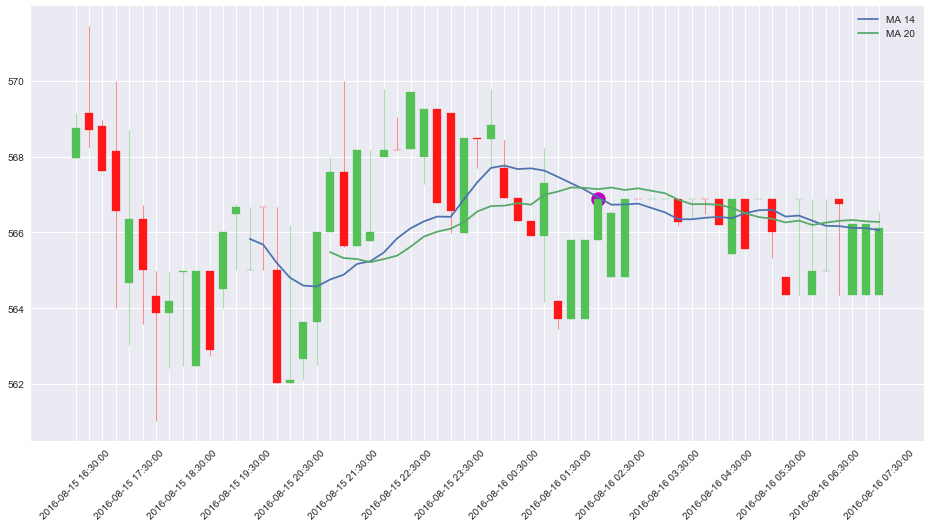

In [193]:
transaction = strategy.exchange.transactions[1999]
plotTransactionWithSurroundings(usdtBtc, 20*96, 14*96, transaction)

In [136]:
transaction

In [83]:
# import time

# allStats = None
# for timePeriod in range(96, 96*30, 96):
#     start_time = time.time()
#     print('timePeriod:', timePeriod, end=' ')
#     simpleMA = SimpleMAStrategy(exchange, usdtBtcManager, timePeriod, contractPair)
#     simpleMA.trade()
#     stats = simpleMA.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
#     stats['timePeriod'] = timePeriod
#     if allStats is None:
#         allStats = stats
#     else:
#         allStats = allStats.append(stats)
#     print("--- %s seconds ---" % (time.time() - start_time))

# Evaluate Statistics Simple MA

In [131]:
allStats.to_csv('results/simpleMA-results.tsv', sep='\t', index=False)

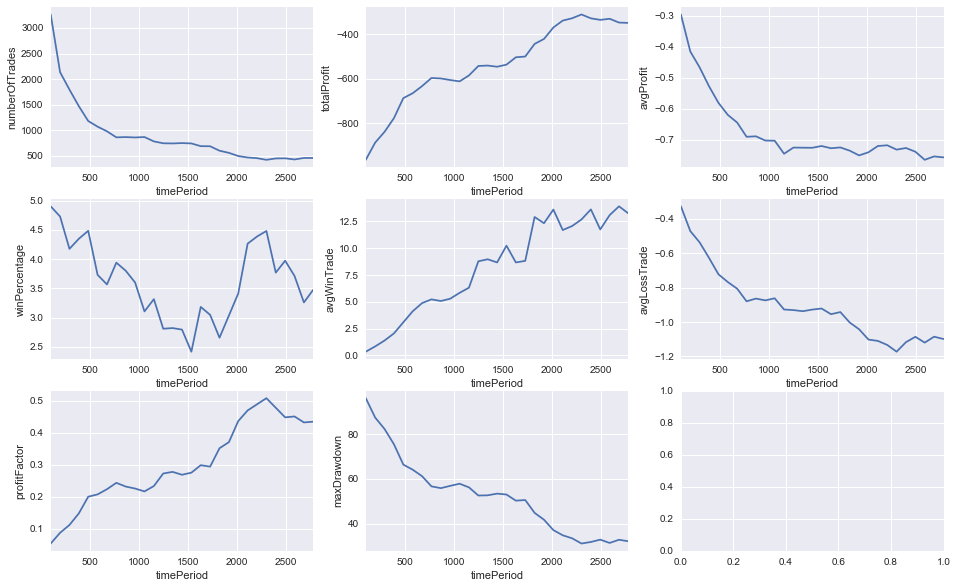

In [147]:
f, axarr = plt.subplots(3, 3, figsize=[16,10])
sns.tsplot(data=allStats, time="timePeriod", value="numberOfTrades", ax=axarr[0, 0])
sns.tsplot(data=allStats, time="timePeriod", value="totalProfit", ax=axarr[0, 1]);
sns.tsplot(data=allStats, time="timePeriod", value="avgProfit", ax=axarr[0, 2]);
sns.tsplot(data=allStats, time="timePeriod", value="winPercentage", ax=axarr[1, 0]);
sns.tsplot(data=allStats, time="timePeriod", value="avgWinTrade", ax=axarr[1, 1]);
sns.tsplot(data=allStats, time="timePeriod", value="avgLossTrade", ax=axarr[1, 2]);
sns.tsplot(data=allStats, time="timePeriod", value="profitFactor", ax=axarr[2, 0]);
sns.tsplot(data=allStats, time="timePeriod", value="maxDrawdown", ax=axarr[2, 1]);

# Conclusion

Strategie Simple moving average, je naprosto nevhodna pro tradovani btc-usd. Jelikoz negenerovala zisk s zadnym parametrem,
vidim ji, jako naprosto nepouzitelnou pro pristi experimenty.